<a href="https://colab.research.google.com/github/ozaanme/MNIST_fastai/blob/main/digit_classifier_Part2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intro


Hi everyone, this is part 2 for MNIST digit classifier. This part differs from the first one in the way of creating our model. In first part, we used ResNet to train our data. In this part, we are going to learn how to use SGD for training data. In addition, I'd like to say that this isn't a content created entirely by me. I wrote this because I think that it helps me to understand concepts in fast.ai book.

In [1]:
! [ -e /content ] && pip install -Uqq fastai  # upgrade fastai on colab
! pip install fastbook
from fastai.vision.all import * 
from fastbook import * 
import ipywidgets as widgets


     |████████████████████████████████| 197 kB 4.3 MB/s 
     |████████████████████████████████| 59 kB 6.2 MB/s 
     |████████████████████████████████| 719 kB 4.2 MB/s 
     |████████████████████████████████| 1.2 MB 39.4 MB/s 


As you can remember from the first after we install fastai on colab, we need to download data.

In [2]:
path = untar_data(URLs.MNIST)

After we download our data lets take a look whats in it.

In [3]:
(path/'training').ls()

(#10) [Path('/root/.fastai/data/mnist_png/training/3'),Path('/root/.fastai/data/mnist_png/training/2'),Path('/root/.fastai/data/mnist_png/training/0'),Path('/root/.fastai/data/mnist_png/training/9'),Path('/root/.fastai/data/mnist_png/training/4'),Path('/root/.fastai/data/mnist_png/training/7'),Path('/root/.fastai/data/mnist_png/training/5'),Path('/root/.fastai/data/mnist_png/training/8'),Path('/root/.fastai/data/mnist_png/training/1'),Path('/root/.fastai/data/mnist_png/training/6')]

As you can see, there are folders contain images of each number. We can also look into these ones(using sorted to ensure we all get the same order of files).

In [4]:
zeros = (path/'training'/'0').ls().sorted()
ones = (path/'training'/'1').ls().sorted()
twos = (path/'training'/'2').ls().sorted()
threes = (path/'training'/'3').ls().sorted()
fours = (path/'training'/'4').ls().sorted()
fives = (path/'training'/'5').ls().sorted()
sixes = (path/'training'/'6').ls().sorted()
sevens = (path/'training'/'7').ls().sorted()
eights = (path/'training'/'8').ls().sorted()
nines = (path/'training'/'9').ls().sorted()
zeros


(#5923) [Path('/root/.fastai/data/mnist_png/training/0/1.png'),Path('/root/.fastai/data/mnist_png/training/0/1000.png'),Path('/root/.fastai/data/mnist_png/training/0/10005.png'),Path('/root/.fastai/data/mnist_png/training/0/10010.png'),Path('/root/.fastai/data/mnist_png/training/0/10022.png'),Path('/root/.fastai/data/mnist_png/training/0/10025.png'),Path('/root/.fastai/data/mnist_png/training/0/10026.png'),Path('/root/.fastai/data/mnist_png/training/0/10045.png'),Path('/root/.fastai/data/mnist_png/training/0/10069.png'),Path('/root/.fastai/data/mnist_png/training/0/10071.png')...]

As expected, it is full of images. Let’s take a look at one now.

In [5]:
im5_path = fives[5]
im5 = Image.open(im5_path)
im5

In this part, it is important to understand what images means to computer. In computers, everything is represented as numbers. In order to review the numbers that create this image, we have to convert it to NumPy array or PyTorch tensor.
Let's first examine NumPy array:

In [6]:
array(im5)[5:15,5:15]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,  17, 176, 165, 197],
       [  0,   0,   0,   0,   0,   0,  47, 252, 252, 252],
       [  0,   0,   0,   0,   0,  24, 253, 253, 253, 243],
       [  0,   0,   0,   0,   0,  24, 252, 252, 172,  50],
       [  0,   0,   0,   0,   0,  24, 252, 252,  77,   0],
       [  0,   0,   0,   0,   0,   5, 135, 252, 194,  51],
       [  0,   0,   0,   0,   0,   0,  26, 137, 232, 242]], dtype=uint8)

5:15 means that we only request the part that includes these columns and rows. And we can also make same thing for a tensor.

In [7]:
tensor(im5)[5:15,5:15]

tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,  17, 176, 165, 197],
        [  0,   0,   0,   0,   0,   0,  47, 252, 252, 252],
        [  0,   0,   0,   0,   0,  24, 253, 253, 253, 243],
        [  0,   0,   0,   0,   0,  24, 252, 252, 172,  50],
        [  0,   0,   0,   0,   0,  24, 252, 252,  77,   0],
        [  0,   0,   0,   0,   0,   5, 135, 252, 194,  51],
        [  0,   0,   0,   0,   0,   0,  26, 137, 232, 242]], dtype=torch.uint8)

We can pick specific part of this tensor, and then use Pandas DataFrame to color-code the values using a gradient.

In [8]:
im5_t = tensor(im5)
df = pd.DataFrame(im5_t[10:25,5:20]) ## This indexes shows us the bottom part of image.
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0,0,0,0,0,24,253,253,253,243,116,42,0,0,0
1,0,0,0,0,0,24,252,252,172,50,0,0,0,0,0
2,0,0,0,0,0,24,252,252,77,0,0,0,0,0,0
3,0,0,0,0,0,5,135,252,194,51,0,0,0,0,0
4,0,0,0,0,0,0,26,137,232,242,0,0,0,0,0
5,0,0,0,0,0,0,0,0,136,251,244,50,0,0,0
6,0,0,0,0,0,0,0,0,0,84,253,173,13,0,0
7,185,163,70,13,0,0,0,0,0,0,137,252,100,0,0
8,159,252,252,215,103,0,0,0,0,0,24,252,183,0,0
9,23,211,252,252,252,221,116,32,0,0,128,252,183,0,0


This data frame really helps us to understand how computer see images. As you can see white pixels are stored as 0 while black is the number 255 and it shades over 0 to 255. Since we understand how computers sees a image, we can move on the our next part. In following parts, we try different ideas to make computer understand which image represent which number.

# Pixel Similarity

Idea behind pixe similarity is finding the average pixel value for every pixel of digits.First step is getting the average of pixel values for each group.

In [9]:
zero_tensors = [tensor(Image.open(o)) for o in zeros]
one_tensors = [tensor(Image.open(o)) for o in ones]
two_tensors = [tensor(Image.open(o)) for o in twos]
three_tensors = [tensor(Image.open(o)) for o in threes]
four_tensors =[tensor(Image.open(o)) for o in fours]
five_tensors = [tensor(Image.open(o)) for o in fives]
six_tensors = [tensor(Image.open(o)) for o in sixes]
seven_tensors = [tensor(Image.open(o)) for o in sevens]
eight_tensors = [tensor(Image.open(o)) for o in eights]
nine_tensors = [tensor(Image.open(o)) for o in nines]

len(nine_tensors),len(zero_tensors)


(5949, 5923)

We can also check that images look good. Since we have now tensors, we need to use fastai's show_image function to display it.

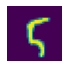

In [10]:
show_image(five_tensors[1]);

For each pixel location, we want to calculate the average of that pixel's intensity over all images. To do this, we combine all images in the list into single three-dimensional tensor. These type of tensors called rank-3 tensor. At this part, we will use stack function that comes with PyTorch. In addition, some operations in PyTorch, such as taking a mean, requires to use float types.
Generally, when images are floats, the pixel values are expected to be between 0 and 1, so we will also divide by 255 here:


In [11]:
stacked_zeros = torch.stack(zero_tensors).float()/255
stacked_ones = torch.stack(one_tensors).float()/255 
stacked_twos = torch.stack(two_tensors).float()/255
stacked_threes = torch.stack(three_tensors).float()/255
stacked_fours = torch.stack(four_tensors).float()/255
stacked_fives = torch.stack(five_tensors).float()/255
stacked_sixes = torch.stack(six_tensors).float()/255
stacked_sevens = torch.stack(seven_tensors).float()/255
stacked_eights = torch.stack(eight_tensors).float()/255
stacked_nines = torch.stack(nine_tensors).float()/255


stacked_threes.shape

torch.Size([6131, 28, 28])

Shape is one of the most important attributes of tensors. It tells us length of each axis. In this example, we have 6131 images each of size 28x28 pixels. We can also find out tensor rank with these methods:


In [12]:
len(stacked_threes.shape),stacked_threes.ndim

(3, 3)

Our next step is calculating the averages. We calculate the mean of the all image tensors by taking the mean along dimension 0 of our stacked, rank-3 tensor.

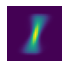

In [13]:
mean1 = stacked_ones.mean(0)
show_image(mean1);


Then we apply same procedure to all of the digits.


In [14]:
mean0 = stacked_zeros.mean(0)
mean2 = stacked_twos.mean(0)
mean3 = stacked_threes.mean(0)
mean4 = stacked_fours.mean(0)
mean5 = stacked_fives.mean(0)
mean6 = stacked_sixes.mean(0)
mean7 = stacked_sevens.mean(0)
mean8 = stacked_eights.mean(0)
mean9 = stacked_nines.mean(0)

Then, we pick arbitrary 4 and measure its distance from our "ideal digits".

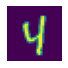

In [15]:
a_4 = stacked_fours[4]
show_image(a_4);

Data scientists use two main ways to measure distance in this context: mean absolute difference and root mean squared error.


*   For mean absolute difference, just take the mean of the absolute value of differences.
*   For RMSE, take the mean of the square of differences (which makes everything positive) and then take the square root (which undoes the squaring). 




Let's try both of them:

In [16]:
dist_4_abs = (a_4 - mean4).abs().mean()
dist_4_sqr = ((a_4 - mean4)**2).mean().sqrt()
dist_4_abs,dist_4_sqr

(tensor(0.1028), tensor(0.1933))

In [17]:
dist_7_abs = (a_4 - mean7).abs().mean()
dist_7_sqr = ((a_4 - mean7)**2).mean().sqrt()
dist_7_abs,dist_7_sqr

(tensor(0.1180), tensor(0.2358))

As you can see, there is less difference with 4 according to 7. So our model will give right prediction in this case.

PyTorch already provides both of these as loss functions. You’ll find these inside
torch.nn.functional, which the PyTorch team recommends importing as F (and is
available by default under that name in fastai):

In [18]:
F.l1_loss(a_4.float(),mean7), F.mse_loss(a_4,mean7).sqrt()


(tensor(0.1180), tensor(0.2358))

Here, MSE stands for mean squared error, and l1 refers to the standard mathematical jargon for mean absolute value.

Let’s create tensors for our digts from validation directory. These are the tensors we will use to calculate a metric measuring the quality of our first-try model, which measures distance from an ideal image:

In [19]:
valid_0_tens = torch.stack([tensor(Image.open(o))
 for o in (path/'testing'/'0').ls()])
valid_0_tens = valid_0_tens.float()/255

valid_1_tens = torch.stack([tensor(Image.open(o))
 for o in (path/'testing'/'1').ls()])
valid_1_tens = valid_1_tens.float()/255

valid_2_tens = torch.stack([tensor(Image.open(o))
 for o in (path/'testing'/'2').ls()])
valid_2_tens = valid_2_tens.float()/255

valid_3_tens = torch.stack([tensor(Image.open(o))
 for o in (path/'testing'/'3').ls()])
valid_3_tens = valid_3_tens.float()/255

valid_4_tens = torch.stack([tensor(Image.open(o))
 for o in (path/'testing'/'4').ls()])
valid_4_tens = valid_4_tens.float()/255

valid_5_tens = torch.stack([tensor(Image.open(o))
 for o in (path/'testing'/'5').ls()])
valid_5_tens = valid_5_tens.float()/255

valid_6_tens = torch.stack([tensor(Image.open(o))
 for o in (path/'testing'/'6').ls()])
valid_6_tens = valid_6_tens.float()/255

valid_7_tens = torch.stack([tensor(Image.open(o))
 for o in (path/'testing'/'7').ls()])
valid_7_tens = valid_7_tens.float()/255

valid_8_tens = torch.stack([tensor(Image.open(o))
 for o in (path/'testing'/'8').ls()])
valid_8_tens = valid_8_tens.float()/255

valid_9_tens = torch.stack([tensor(Image.open(o))
 for o in (path/'testing'/'9').ls()])
valid_9_tens = valid_9_tens.float()/255


valid_3_tens.shape,valid_7_tens.shape ##It’s good to get in the habit of checking shapes as you go. 

(torch.Size([1010, 28, 28]), torch.Size([1028, 28, 28]))

Next,We can write a simple function that calculates the mean absolute error using an expression very similar to the one we wrote in the last section:

In [20]:
def mnist_distance(a,b): return (a-b).abs().mean((-1,-2))
mnist_distance(a_4, mean4)


tensor(0.1028)

In addition, we can also call this function with tensors. Let's try it and see what happens?

In [21]:
valid_3_dist = mnist_distance(valid_3_tens, mean3)
valid_3_dist, valid_3_dist.shape


(tensor([0.1366, 0.1234, 0.1268,  ..., 0.1224, 0.1778, 0.1430]),
 torch.Size([1010]))

As you can see, , it returned the distance for every single image as a vector (i.e., a rank-1 tensor) of length 1,010 (the number of 3s in our validation set). Then, we can define another function to understand which digit is the given picture.

In [22]:
def is_what(x):
  find_array = [mnist_distance(x,mean0),mnist_distance(x,mean1),mnist_distance(x,mean2),mnist_distance(x,mean3),mnist_distance(x,mean4),
                mnist_distance(x,mean5),mnist_distance(x,mean6),mnist_distance(x,mean7),mnist_distance(x,mean8),mnist_distance(x,mean9)]
  index, elem = min(enumerate(find_array), key=itemgetter(1))
  return(index,elem)

is_what(a_4)

(4, tensor(0.1028))

With this function, we can see that our model works or not and you can give couple of try to understand it better. Differs from the book example, we compare all digits. Therefore, accuracy will be way lower than we aim with this method. We need something better.

# Stochastic Gradient Descent

In this part, I am not going to explain what is SGD since there is great part in fast.ai book which explains SGD very well. However, I will start with same example in the book to illustrate with basic concepts.

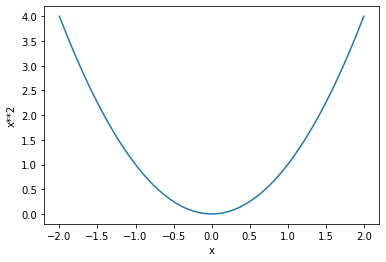

In [23]:
def f(x): return x**2

## With graph

plot_function(f, 'x', 'x**2')

PyTorch is able to automatically compute the derivative of nearly any function Most of the time, it will be at least as fast as any derivative function that you can create by hand. 

Let’s see an
example.
First, let’s pick a tensor value at which we want gradients:

In [24]:
xt = tensor(3.).requires_grad_()

requires_grad is the function that we use to tell PyTorch that we want to calculate gradients with respect to that variable at that value.

Now let's calculate our function with that value and check whether we see something interesting.

In [25]:
yt = f(xt)
yt

tensor(9., grad_fn=<PowBackward0>)

As you can see, PyTorch prints not just the value calculated, but also note that we mark that with gradient operation.

Finally, we tell PyTorch to calculate the gradients for us:

In [26]:
yt.backward()

We can now view the gradients by checking the grad attribute of our tensor:

In [27]:
xt.grad

tensor(6.)

As you all know, derrivative of x**2 is 2*x, and we pick x=3, so the gradients must be 2*3 = 6 which is the same result PyTorch gives us.


Now, we'll repeat same steps with a vector arguments:


In [28]:
xt = tensor([3.,4.,10.]).requires_grad_()
xt

tensor([ 3.,  4., 10.], requires_grad=True)

And we’ll add sum to our function so it can take a vector (i.e., a rank-1 tensor) and
return a scalar (i.e., a rank-0 tensor):


In [29]:
def f(x): return (x**2).sum()
yt = f(xt)
yt


tensor(125., grad_fn=<SumBackward0>)

Our gradients are 2*xt, as we’d expect!

In [30]:
yt.backward()
xt.grad

tensor([ 6.,  8., 20.])

Now, it is time to understand concept of learning rate. Most of the approaches start with multiplying gradient with some small number, learning rate. The learning rate is often a number between 0.001 and 0.1, although it could be any‐
thing. Once you’ve picked a learning rate, you can adjust your parameters using this simple function:

In [31]:
w -= w.grad * lr

NameError: ignored

This is known as stepping your parameters, using an optimization step. If you pick learning rate that's too low, it means you have to do a lot of steps.
If you pick it too high, that's worse. It may ends up loss getting worse.If the learning rate is too high, it may also “bounce” around, rather than diverging.


Now let's move on to end-to-end SGD example. 


Let's start with a very basic, synthetic model. Assume you're measuring the speed of a roller coaster as it passes over a bump. It would start quickly and then slow as it climbed the hill; it would be the slowest at the top and then speed up as it descended. You'd like to create a model that shows how speed changes over time. If you were to manually measure the speed every second for 20 seconds, it would look like this:

In [32]:
time = torch.arange(0,20).float(); time

tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15., 16., 17., 18., 19.])

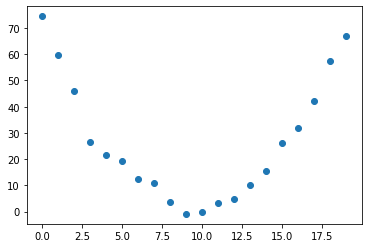

In [33]:
speed = torch.randn(20)*3 + 0.75*(time-9.5)**2 + 1
plt.scatter(time,speed);

We can use SGD to look for a function that matches our observations. We won't be able to consider every potential function, so we'll assume it'll be quadratic, i.e., a function of the form a*(time**2)+(b*time)+c.

In [34]:
def f(t, params):
 a,b,c = params
 return a*(t**2) + (b*t) + c

In other words, the task of finding the best conceivable function that matches the data has been narrowed down to finding the best quadratic function. Because every quadratic function is fully specified by the three parameters a, b, and c, this substantially simplifies the problem. As a result, we just need to discover the optimum values for a, b, and c to find the best quadratic function. In addition, if we can solve this for three parameters, we can apply same approach for other, more complex functions.

In [35]:
def mse(preds, targets): return ((preds-targets)**2).mean()

Now, let's work through our seven-step process.

**Step 1: Initialize the parameters**

First, we initialize the parameters to random values and tell PyTorch that we want to track their gradients using requires_grad_:


In [36]:
params = torch.randn(3).requires_grad_()

**Step 2: Calculate the predictions**


In [37]:
preds = f(time, params)

In this part, we can create a function to compare our predictions with our target.

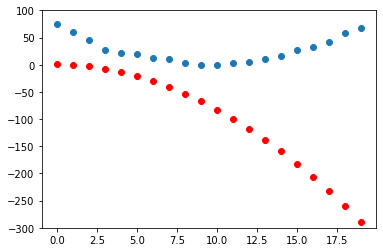

In [38]:
def show_preds(preds, ax=None):
 if ax is None: ax=plt.subplots()[1]
 ax.scatter(time, speed)
 ax.scatter(time, to_np(preds), color='red')
 ax.set_ylim(-300,100)
show_preds(preds)

**Step 3: Calculate the loss**

In [39]:
loss = mse(preds, speed)
loss

tensor(25823.8086, grad_fn=<MeanBackward0>)

Our goal is now to improve this. To do that, we’ll need to know the gradients.


**Step 4: Calculate the gradients**

In [ ]:
loss.backward()
params.grad

In [41]:
params.grad * 1e-5

tensor([-0.5320, -0.0342, -0.0025])

We can use these gradients to improve our parameters. We’ll need to pick a learning rate for now, we’ll just use 1e-5.

In [42]:
params

tensor([-0.7658, -0.7506,  1.3525], requires_grad=True)

**Step 5: Step the weights**

Now we need to update the parameters based on the gradients just calculated.

In [43]:
lr = 1e-5
params.data -= lr * params.grad.data
params.grad = None

Let's check that loss improved:

In [44]:
preds = f(time,params)
mse(preds, speed)

tensor(5435.5356, grad_fn=<MeanBackward0>)

We need to repeat this a few times, so it is useful to create function:


In [45]:
def apply_step(params, prn=True):
 preds = f(time, params)
 loss = mse(preds, speed)
 loss.backward()
 params.data -= lr * params.grad.data
 params.grad = None
 if prn: print(loss.item())
 return preds


**Step 6: Repeat the process**

In [46]:
for i in range(7): apply_step(params)

5435.53564453125
1577.44921875
847.3778076171875
709.2225341796875
683.0758056640625
678.1243896484375
677.1838989257812


**Step 7: Stop**

We just decided to stop after 10 epochs. In reality, we'd keep an eye on the training and validation losses, as well as our metrics, to determine when to stop.

# The MNIST Loss Function

We already have our xs—the photographs themselves—as independent variables.
We'll combine them all into a single tensor and convert them from a list of matrices(a rank-3 tensor)  to a list of vectors (a rank-2 tensor). This may be accomplished with view, a PyTorch technique that alters the form of a tensor without altering its contents. - 1 is a specific view parameter that says "make this axis as big as it has to be to fit all of the data":

In [47]:
train_x = torch.cat([stacked_threes, stacked_eights]).view(-1, 28*28)
                    

We need a label for each image. We’ll use 1 for 3s and 0 for 8s:

In [48]:
train_y = tensor([1]*len(threes) + [0]*len(eights)).unsqueeze(1)
train_x.shape,train_y.shape

(torch.Size([11982, 784]), torch.Size([11982, 1]))

When indexed in PyTorch, a Dataset must return a tuple of (x,y). Python has a zip function that, when used with list, gives a straightforward method to achieve this:

In [49]:
dset = list(zip(train_x,train_y))
x,y = dset[0]
x.shape,y

(torch.Size([784]), tensor([1]))

In [51]:
valid_x = torch.cat([valid_3_tens, valid_8_tens]).view(-1, 28*28)
valid_y = tensor([1]*len(valid_3_tens) + [0]*len(valid_8_tens)).unsqueeze(1)
valid_dset = list(zip(valid_x,valid_y))

Now we need a random weight for every pixel.

In [52]:
def init_params(size, std=1.0): return (torch.randn(size)*std).requires_grad_()
weights = init_params((28*28,1))

The function weights*pixels won’t be flexible enough—it is always equal to 0 when
the pixels are equal to 0 (i.e., its intercept is 0). You might remember from high school
math that the formula for a line is y=w*x+b; we still need the b. We’ll initialize it to a
random number too:


In [53]:
bias = init_params(1)

We can now calculate a prediction for one image:


In [54]:
(train_x[0]*weights.T).sum() + bias

tensor([20.2336], grad_fn=<AddBackward0>)

While we could calculate the prediction for each image using a Python for loop, this would be extremely slow.In this case, there’s an extremely convenient mathematical operation that calculates w*x for every row of a matrix—it’s called matrix multiplication. In Python, matrix multiplication is represented with the @ operator. Let’s try it:

In [55]:
def linear1(xb): return xb@weights + bias
preds = linear1(train_x)
preds

tensor([[20.2336],
        [17.0644],
        [15.2384],
        ...,
        [15.4866],
        [19.8041],
        [20.5976]], grad_fn=<AddBackward0>)

Let's check our accuracy. To determine if each output represents a 3 or a 8, we just check whether it is bigger than 0, allowing us to measure our accuracy for each item (using broadcasting, so no loops!) the following:

In [56]:
corrects = (preds>0.0).float() == train_y
corrects

tensor([[ True],
        [ True],
        [ True],
        ...,
        [False],
        [False],
        [False]])

In [57]:
corrects.float().mean().item()

0.5104323029518127

Now let’s see what the change in accuracy is for a small change in one of the weights:



In [62]:
weights.data[0] *=1.0001

In [63]:
preds = linear1(train_x)
((preds>0.0).float() == train_y).float().mean().item()

0.5104323029518127

As we’ve seen, we need gradients in order to improve our model using SGD, and in
order to calculate gradients we need a loss function that represents how good our
model is. That is because the gradients are a measure of how that loss function
changes with small tweaks to the weights. Then, let's write a loss function that helps us.

In [64]:
def mnist_loss(predictions, targets):
 predictions = predictions.sigmoid()
 return torch.where(targets==1, 1-predictions, predictions).mean()

Now that we have a loss function suitable for driving SGD, we can consider some of
the details involved in the next phase of the learning process, which is to change or
update the weights based on the gradients. "This is called an optimization step.
To take an optimization step, we need to calculate the loss over one or more data
items. How many should we use?... Calculating it for the whole dataset would take a long time. Calculating it for a single
item would not use much information, so it would result in an imprecise and unsta‐
ble gradient. So instead we compromise: we calculate the average loss for a few data items at a
time. This is called a mini-batch...One simple and effective thing we can
vary is what data items we put in each mini-batch. Rather than simply enumerating
our dataset in order for every epoch, instead what we normally do is randomly shuffle
it on every epoch, before we create mini-batches. PyTorch and fastai provide a class
that will do the shuffling and mini-batch collation for you, called DataLoader.
A DataLoader can take any Python collection and turn it into an iterator over many
batches, like so:" (This part directly taken from fast.ai book page.170 highly recommended to read)

In [65]:
coll = range(15)
dl = DataLoader(coll, batch_size=5, shuffle=True)
list(dl)

[tensor([ 3, 12,  8, 10,  2]),
 tensor([ 9,  4,  7, 14,  5]),
 tensor([ 1, 13,  0,  6, 11])]

We don't simply want any Python collection for training a model; we want a collection with independent and dependent variables (the inputs and targets of the model). A Dataset is a PyTorch collection that comprises tuples of independent and dependent variables. Here is an example of a very basic Dataset:

In [66]:
ds = L(enumerate(string.ascii_lowercase))
ds

(#26) [(0, 'a'),(1, 'b'),(2, 'c'),(3, 'd'),(4, 'e'),(5, 'f'),(6, 'g'),(7, 'h'),(8, 'i'),(9, 'j')...]

Then lets see what happen if we pass Dataset to a DataLoader:

In [67]:
dl = DataLoader(ds, batch_size=6, shuffle=True)
list(dl)

[(tensor([17, 18, 10, 22,  8, 14]), ('r', 's', 'k', 'w', 'i', 'o')),
 (tensor([20, 15,  9, 13, 21, 12]), ('u', 'p', 'j', 'n', 'v', 'm')),
 (tensor([ 7, 25,  6,  5, 11, 23]), ('h', 'z', 'g', 'f', 'l', 'x')),
 (tensor([ 1,  3,  0, 24, 19, 16]), ('b', 'd', 'a', 'y', 't', 'q')),
 (tensor([2, 4]), ('c', 'e'))]

We get back many batches that are
themselves tuples of tensors representing batches of independent and dependent
variables.

We are now ready to write our first training loop for a model using SGD!

In [69]:
for x,y in dl:
 
 loss = loss_func(pred, y)
 loss.backward()
 parameters -= parameters.grad * lr

NameError: ignored